# Utilizing cPeaks in ArchR pipeline: An example

This jupyter notebook is adapted from [A Brief Tutorial of ArchR](https://www.archrproject.com/articles/Articles/tutorial.html)

## Getting Set Up

First, we load the ArchR library. If loading ArchR fails, you have not properly installed ArchR and should [revisit the installation instructions](https://www.archrproject.com/index.html). We load other useful libraries too. Install them before you load them. We also recommend setting and remembering a known seed to facilitate replication of operations requiring randomization.

In [1]:
library(ArchR)
library(GenomicRanges)
library(tidyverse)
library(dplyr)
library(parallel)
set.seed(1)

Next, we set the default number of threads for parallelized operations in ArchR functions. You should change the value passed to threads to match the specifications of your local machine.

In [2]:
addArchRThreads(threads = 16)

Input threads is equal to or greater than ncores minus 1 (7)
Setting cores to ncores minus 2. Set force = TRUE to set above this number!

Setting default number of Parallel threads to 6.



The Hematopoeisis tutorial data can be downloaded using the [getTutorialData()](https://www.archrproject.com/reference/getTutorialData.html) function. The tutorial data is approximately 0.5 GB in size. If you have already downloaded the tutorial in the current working directory, ArchR will bypass downloading.

In [3]:
inputFiles <- getTutorialData("Hematopoiesis")
inputFiles

scATAC_BMMC_R1 
     "HemeFragments/scATAC_BMMC_R1.fragments.tsv.gz" 
                                 scATAC_CD34_BMMC_R1 
"HemeFragments/scATAC_CD34_BMMC_R1.fragments.tsv.gz" 
                                      scATAC_PBMC_R1 
     "HemeFragments/scATAC_PBMC_R1.fragments.tsv.gz"

Before we begin, we need add a reference genome annotation for ArchR to have access to chromosome and gene information. ArchR natively supports hg19, hg38, mm9, and mm10.

In [4]:
addArchRGenome('hg19')

Setting default genome to Hg19.



## Creating Arrow Files

Now we will create our Arrow files which will take 10-15 minutes. For each sample, this step will:

1. Read accessible fragments from the provided input files.
2. Calculate quality control information for each cell (i.e. TSS enrichment scores and nucleosome info).
3. Filter cells based on quality control parameters.
4. Create a genome-wide TileMatrix using 500-bp bins.
5. Create a GeneScoreMatrix using the custom geneAnnotation that was defined when we called [addArchRGenome()](https://www.archrproject.com/reference/addArchRGenome.html).


In [5]:
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = names(inputFiles),
  minTSS = 4, #Dont set this too high because you can always increase later
  minFrags = 1000, 
  addTileMat = TRUE,
  addGeneScoreMat = TRUE
)

Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

ArchR logging to : ArchRLogs/ArchR-createArrows-11abd30b425b5-Date-2024-03-09_Time-23-17-46.468419.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2024-03-09 23:17:46.725493 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-11abd30b425b5-Date-2024-03-09_Time-23-17-46.468419.log



We can inspect the `ArrowFiles` object to see that it is actually just a character vector of Arrow file paths.

In [6]:
ArrowFiles

[1] "scATAC_BMMC_R1.arrow"      "scATAC_CD34_BMMC_R1.arrow"
[3] "scATAC_PBMC_R1.arrow"

## Inferring Doublets

After Arrow file creation, we can infer potential doublets (a single droplet containing multiple cells) that can confound downstream results. This is done using the [addDoubletScores()](https://www.archrproject.com/reference/addArchRGenome.html) function.

In [7]:
doubScores <- addDoubletScores(
  input = ArrowFiles,
  k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
  knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search.
  LSIMethod = 1
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-11abd317a70e-Date-2024-03-09_Time-23-30-25.754935.log
If there is an issue, please report to github with logFile!

2024-03-09 23:30:26.237805 : Batch Execution w/ safelapply!, 0 mins elapsed.

2024-03-09 23:30:26.297132 : scATAC_BMMC_R1 (1 of 3) :  Computing Doublet Statistics, 0.001 mins elapsed.

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

scATAC_BMMC_R1 (1 of 3) : UMAP Projection R^2 = 0.97882

scATAC_BMMC_R1 (1 of 3) : UMAP Projection R^2 = 0.97882

2024-03-09 23:33:18.521463 : scATAC_CD34_BMMC_R1 (2 of 3) :  Computing Doublet Statistics, 2.871 mins elapsed.

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'B

## Creating an `ArchRProject`

With our Arrow files in hand, we are now ready to create an `ArchRProject`. An `ArchRProject` is associated with a set of Arrow files and is the backbone of nearly all ArchR analyses.

In [8]:
proj <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = "HemeTutorial",
  copyArrows = TRUE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

Validating Arrows...

Getting SampleNames...



Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 
2 
3 


Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--'

Now we can filter putative doublets based on the previously determined doublet scores using the [filterDoublets()](https://www.archrproject.com/reference/filterDoublets.html) function. This doesn’t physically remove data from the Arrow files but rather tells the `ArchRProject` to ignore these cells for downstream analysis.

In [9]:
proj <- filterDoublets(ArchRProj = proj)

Filtering 410 cells from ArchRProject!

	scATAC_BMMC_R1 : 243 of 4932 (4.9%)

	scATAC_CD34_BMMC_R1 : 107 of 3275 (3.3%)

	scATAC_PBMC_R1 : 60 of 2453 (2.4%)



## Dimensionality Reduction and Clustering

ArchR implements an iterative LSI dimensionality reduction via the [addIterativeLSI()](https://www.archrproject.com/reference/addIterativeLSI.html) function. Here, we use cPeaks as the Matrix features.

In [10]:
cpeaks <- read_table('../data/cpeaks_hg19.bed', col_names = F)
cpeaks.gr <- GRanges(seqnames = cpeaks$X1, ranges = IRanges(cpeaks$X2, cpeaks$X3))
proj <- addFeatureMatrix(proj, features = cpeaks.gr, matrixName = 'FeatureMatrix')
proj <- addIterativeLSI(ArchRProj = proj, useMatrix = "FeatureMatrix", name = "IterativeLSI")


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double()
)

ArchR logging to : ArchRLogs/ArchR-addFeatureMatrix-11abd56712162-Date-2024-03-09_Time-23-37-33.498168.log
If there is an issue, please report to github with logFile!

2024-03-09 23:37:36.526845 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addFeatureMatrix-11abd56712162-Date-2024-03-09_Time-23-37-33.498168.log

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-11abd1d46d544-Date-2024-03-09_Time-23-38-49.388745.log
If there is an issue, please report to github with logFile!

2024-03-09 23:38:50.432686 : Computing Total Across All Features, 0.004 mins elapsed.

2024-03-09 23:38:56.831526 : Computing Top Features, 0.11 mins elapsed.

###########
2024-03-09 23:38:59.23302 : Running LSI (1 of 2) o

To call clusters in this reduced dimension sub-space, we use the [addClusters()](https://www.archrproject.com/reference/addClusters.html) function which uses [Seurat’s](https://satijalab.org/seurat/) graph clustering as the default clustering method.

In [11]:
proj <- addClusters(input = proj, reducedDims = "IterativeLSI")

ArchR logging to : ArchRLogs/ArchR-addClusters-11abd5e1faebc-Date-2024-03-09_Time-23-41-38.584593.log
If there is an issue, please report to github with logFile!

2024-03-09 23:41:39.065731 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.002 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10250
Number of edges: 443768

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8804
Number of communities: 15
Elapsed time: 1 seconds


2024-03-09 23:41:54.177683 : Testing Outlier Clusters, 0.254 mins elapsed.

2024-03-09 23:41:54.185797 : Assigning Cluster Names to 15 Clusters, 0.254 mins elapsed.

2024-03-09 23:41:54.285015 : Finished addClusters, 0.255 mins elapsed.



## Visualizing in a 2D UMAP Embedding

We can visualize our scATAC-seq data using a 2-dimensional representation such as Uniform Manifold Approximation and Projection (UMAP). To do this, we add a UMAP embedding to our ArchRProject object with the [addUMAP()](https://www.archrproject.com/reference/addUMAP.html) function. This function uses the [uwot package](https://github.com/jlmelville/uwot) to perform UMAP.

23:41:54 UMAP embedding parameters a = 0.7669 b = 1.223

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

23:41:54 Read 10250 rows and found 30 numeric columns

23:41:54 Using Annoy for neighbor search, n_neighbors = 40

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

23:41:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

23:41:55 Writing NN index file to temp file /var/folders/mh/r41d5j4s6pl3c6hy_nb613700000gn/T//Rtmpa7ZEAE/file11abd7208e8ea

23:41:55 Searching Annoy index using 4 threads, search_k = 4000

23:41:57 Annoy recall = 100%

23:41:57 Commencing smooth kNN distance calibration using 4 threads
 with target n_neighbors = 40

23

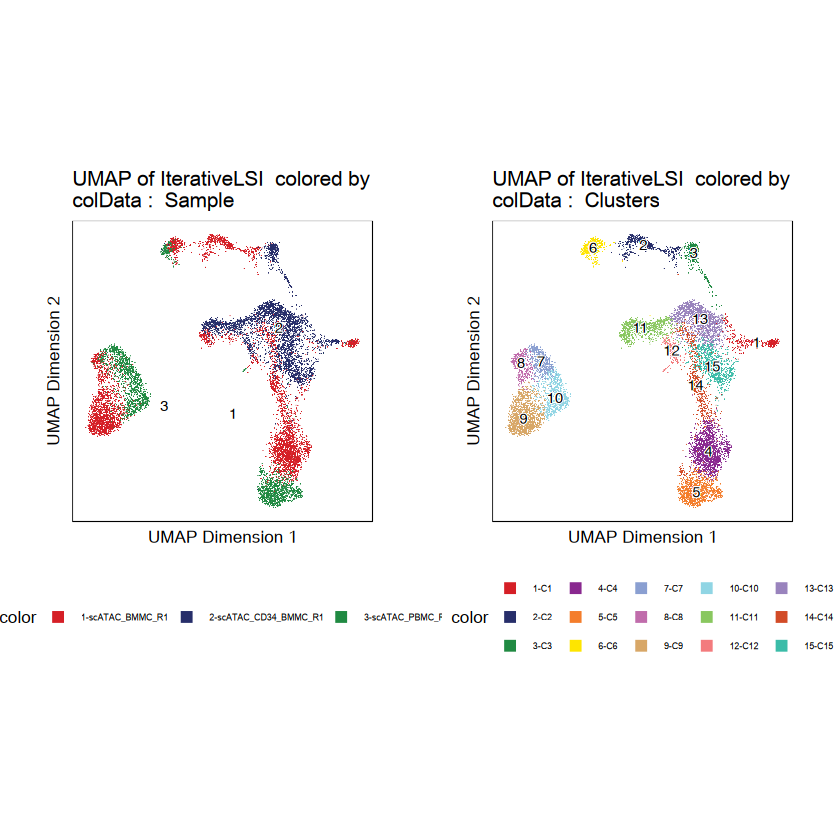

In [12]:
proj <- addUMAP(ArchRProj = proj, reducedDims = "IterativeLSI")  
p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Sample", embedding = "UMAP")    
p2 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")    


In [13]:
options(repr.plot.width = 15, repr.plot.height = 8)

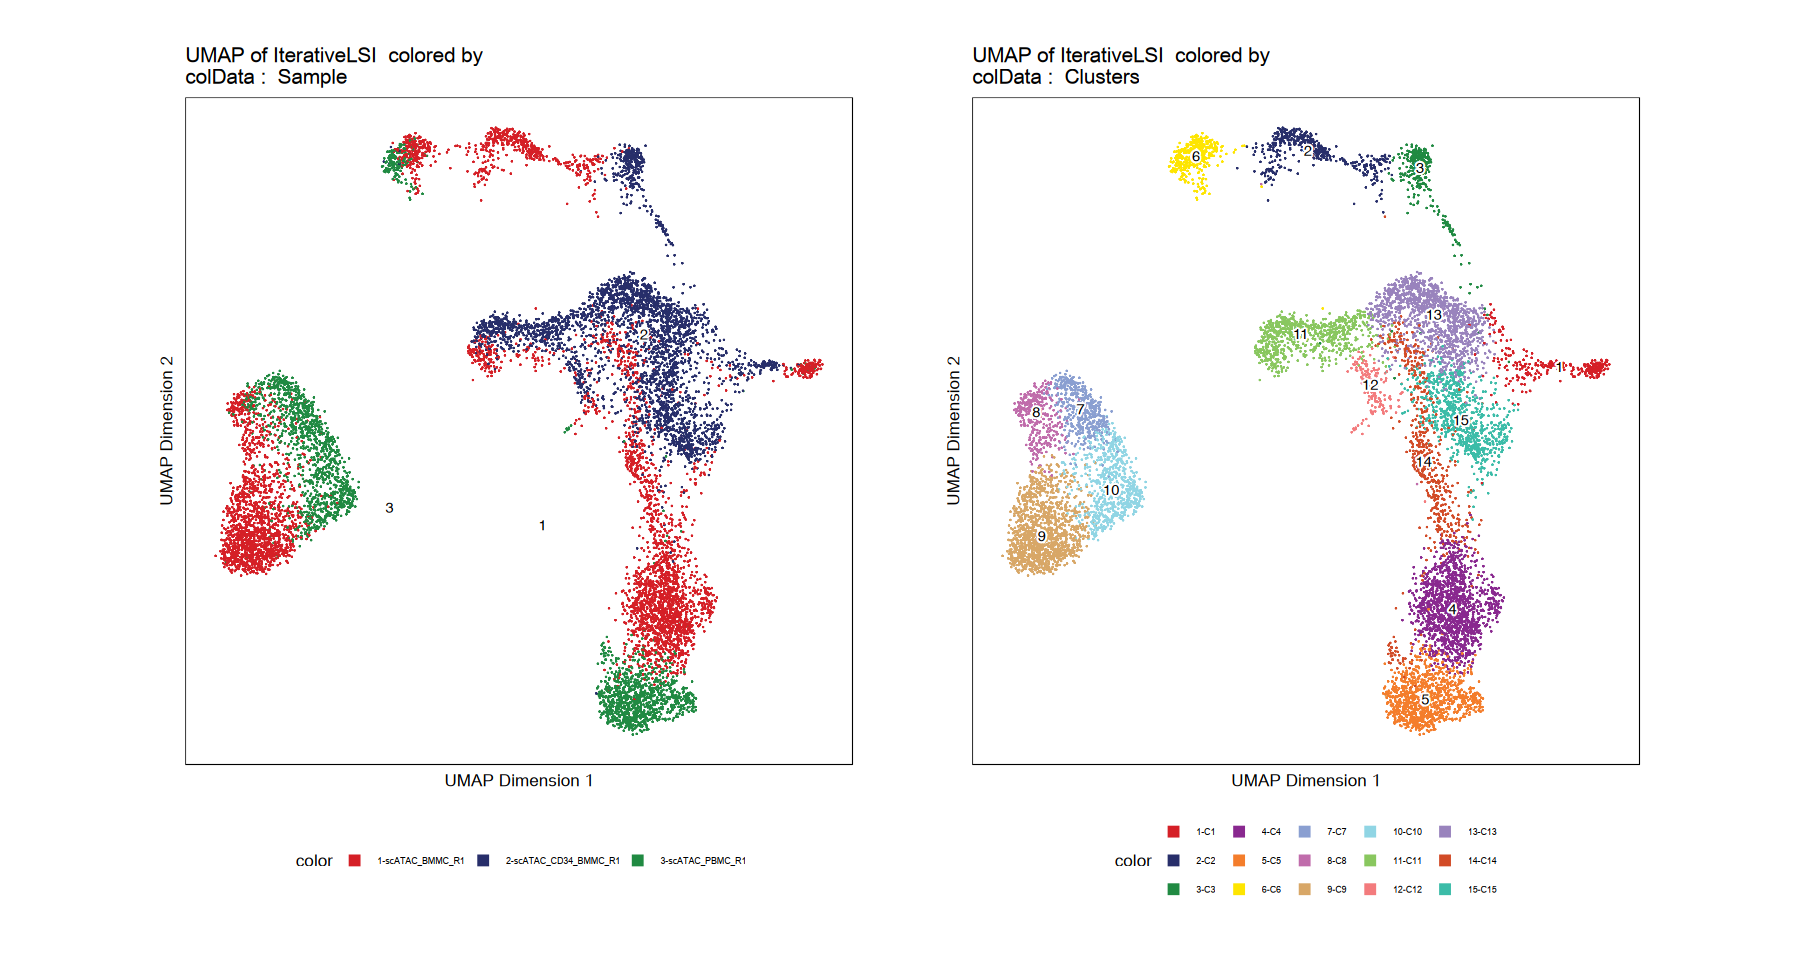

In [14]:
ggAlignPlots(p1, p2, type = "h")